importing the modules required for neural network

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.space import Categorical

libraries added to implement bayesian optimization

In [18]:
import warnings
from bayes_opt.constraint import ConstraintModel
from bayes_opt import BayesianOptimization, UtilityFunction, util
# from .target_space import TargetSpace
# from .event import Events, DEFAULT_EVENTS
# from .logger import _get_default_logger
# from .util import UtilityFunction, acq_max, ensure_rng
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import roc_auc_score

from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold

importing the dataset

In [19]:
df = pd.read_csv("ercot-dataset.csv", sep=',')
# to change the float to two decimal places following code is used
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#df = df.iloc[:80000]
print(df)

                   Date  DryBulb  DewPnt  WetBulb  Humidity  ElecPrice  Day  \
0         1/1/2006 0:30    23.90   21.65    22.40     87.50      19.67    1   
1         1/1/2006 1:00    23.90   21.70    22.40     88.00      18.56    1   
2         1/1/2006 1:30    23.80   21.65    22.35     88.00      19.09    1   
3         1/1/2006 2:00    23.70   21.60    22.30     88.00      17.40    1   
4         1/1/2006 2:30    23.70   21.60    22.30     88.00      17.00    1   
...                 ...      ...     ...      ...       ...        ...  ...   
87643  31/12/2010 22:00    22.60   19.10    20.40     81.00      23.86   31   
87644  31/12/2010 22:30    22.45   19.05    20.30     81.50      26.49   31   
87645  31/12/2010 23:00    22.30   19.00    20.20     82.00      25.18   31   
87646  31/12/2010 23:30    22.05   19.05    20.15     83.50      26.19   31   
87647     1/1/2011 0:00    21.80   19.10    20.10     85.00      24.62    1   

       Month  Year  Minutes  SYSLoad  
0          1

In [20]:
# prints the high level information about the data
'''df.info()'''

'df.info()'

In [21]:
# gives additional statistical information
'''df.describe()'''

'df.describe()'

In [22]:
# to check the total missing data on each features
# zero indicates there is no missing data values
df.isnull().sum()
#df1 = df.drop(['Date','Month','Year', 'Day','Minutes'], axis=1)
df1 = df.drop(['Date','Year'], axis=1)

In [23]:
# df1.corr()
# # to see the correlation between features
# # this helps to see how one parameters has effects on others
# # lets see the plot of correlation data
# sns.heatmap(df1.corr(), annot= True)
# plt.rcParams["figure.figsize"]=(15,10)
# plt.title('Correlation Matrix', fontsize=16)
# plt.show()

In [24]:
# this will select all the rows and columns except the last one from df and assign to x variable
# df1 does not contain the date in the first column in string format
x = df1.iloc[:,:-1].values
#x = df1.iloc[:,1].values
# quality is taken target variable and it in last column and is assigned to y variable
y = df1.iloc[:,-1].values
# encoding the categorical data using onehotencoder this is for classification tasks
'''ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [3])], remainder = 'passthrough')
x = ct.fit_transform(x)
x = x.toarray() # converts encoded data to dense array (optional) would show error without this'''

"ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [3])], remainder = 'passthrough')\nx = ct.fit_transform(x)\nx = x.toarray() # converts encoded data to dense array (optional) would show error without this"

Splitting the dataset into the training and test set

In [25]:
from sklearn.model_selection import train_test_split
# we will split the data into training and testing data using following code
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)
# print(f'Standard deviation of test data: {x_test.std()}')
# print(f'mean of test data: {x_test.mean()}')
# print(f'Standard deviation of train data: {x_train.std()}')
# print(f'mean deviation of train data: {x_train.mean()}')

feature standardization and conversion to tensor

In [26]:
# Feature Scaling (not necessary for neural networks, but can be applied)
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

# # print(f'Standard deviation of test data: {x_test.std()}')
# # print(f'mean of test data: {x_test.mean()}')
# # print(f'Standard deviation of train data: {x_train.std()}')
# # print(f'mean of train data: {x_train.mean()}')
# # Convert data to PyTorch tensors
# x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)

# x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

# # Create a PyTorch dataset and DataLoader
# train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)
# len(x_train)
# #len(test_loader)

Deep Neural Network model with default hyperparameters Prior to HPO

The Model performance parameter with default Hyperparameter in NN algorithm:
Mean Squared Error: 1097136.4262224976
Mean Absolute Error: 875.670222177026
r2_score: 0.45457877133998115


c:\Users\shumagai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


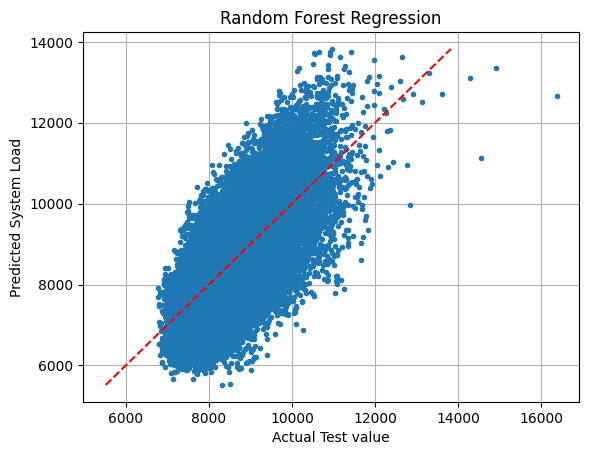

In [27]:
from sklearn.neural_network import MLPRegressor

# Define the model
model = MLPRegressor(hidden_layer_sizes=(64), activation='relu',learning_rate_init=0.01, max_iter=30)

# Train the model
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)

# performance metrics
R2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("The Model performance parameter with default Hyperparameter in NN algorithm:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", R2_score)


plt.plot(y_pred,y_test, '.')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit')
plt.title('Random Forest Regression')
plt.xlabel('Actual Test value')
plt.ylabel('Predicted System Load')
plt.grid(True)
plt.show()

Function definition for NN algorithm

In [28]:
def MLPRegressor_hpo(learning_rate_init, hidden_layer_sizes, max_iter, activation):
    model = MLPRegressor(learning_rate_init=learning_rate_init, hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, activation=activation)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    return y_pred, -mse

Bayesian Optimization in NN

In [29]:
# Define the search space for hyperparameters
pbounds = {'hidden_layer_sizes': Integer(10,200),'max_iter':(10,100),'learning_rate_init': (1e-5, 1e-1),
           'activation': Categorical(['identity', 'logistic', 'tanh', 'relu'])}

nn_model = MLPRegressor()


optimizer = BayesSearchCV(
    estimator=nn_model,
    search_spaces=pbounds,
    n_iter=100,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1
)

# Perform optimization
optimizer.fit(x_train, y_train)

# Get the best hyperparameters
best_params = optimizer.best_params_
# best_score = optimizer.best_score_

print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error with Cross-Validation:", best_score)

# assign variable with best hyperparameters
best_learning_rate_init = best_params['learning_rate_init']
best_hidden_layer_sizes = best_params['hidden_layer_sizes']
best_max_iter = best_params['max_iter']
best_activation = best_params['activation']

y_pred, mse = MLPRegressor_hpo(best_learning_rate_init, best_hidden_layer_sizes , best_max_iter, best_activation)

print("Best Mean Squared Error with Cross-Validation:", mse)  # Convert back to positive MSE

c:\Users\shumagai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Hyperparameters: OrderedDict({'activation': 'identity', 'hidden_layer_sizes': 151, 'learning_rate_init': 0.08126537109817784, 'max_iter': 21})
Best Mean Squared Error with Cross-Validation: -1375391.4423790083


The Model performance parameter after HPO using Bayesian Optimizatoin in NN algorithm:
Mean Squared Error: 1375391.4423790083
Mean Absolute Error: 963.9768559958901
r2_score: 0.3162493993808011


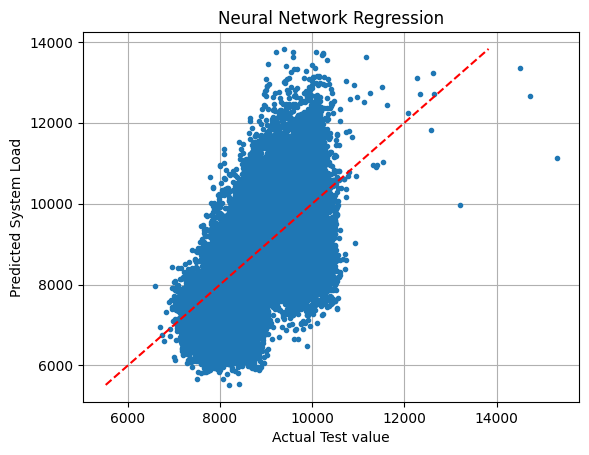

In [30]:
R2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("The Model performance parameter after HPO using Bayesian Optimizatoin in NN algorithm:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", R2_score)

plt.plot(y_pred,y_test, '.')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit')
plt.title('Neural Network Regression')
plt.xlabel('Actual Test value')
plt.ylabel('Predicted System Load')
plt.grid(True)
plt.show()

lets implement random search optimization for Neural Network Algorithm

In [31]:
from sklearn.model_selection import RandomizedSearchCV
# Define the hyperparameter grid
param_grid = {
    'hidden_layer_sizes': (10, 200), 'max_iter':(10,100),'learning_rate_init': (1e-5, 1e-1), 'activation': Categorical(['identity', 'logistic', 'tanh', 'relu'])
}

nn = MLPRegressor()
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=nn, 
                                   param_distributions=param_grid, 
                                   n_iter=100, 
                                   cv=5, 
                                   scoring='neg_mean_squared_error',
                                   random_state=42,
                                   n_jobs=-1)

# Perform the search
random_search.fit(x_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Negative Mean Squared Error:", best_score)



Best Hyperparameters: {'activation': 'logistic', 'hidden_layer_sizes': 10, 'learning_rate_init': 1e-05, 'max_iter': 10}
Best Negative Mean Squared Error: -81180003.9887481


c:\Users\shumagai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


The Model performance parameter after HPO using Random Search in NN algorithm:
Mean Squared Error: 80708517.15060443
Mean Absolute Error: 8871.134115571489
r2_score: -39.12275733034832


c:\Users\shumagai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


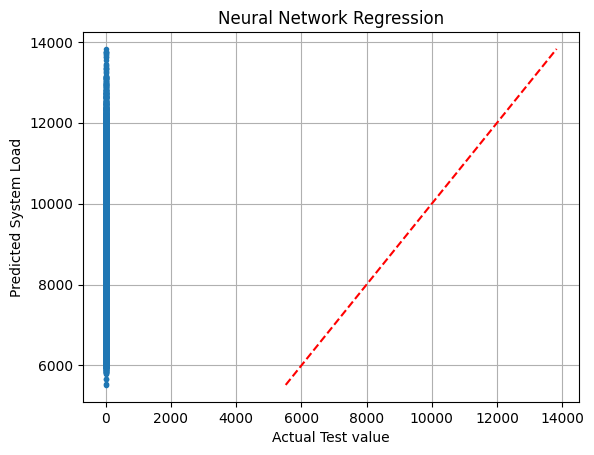

In [32]:
# assign variable with best hyperparameters
best_learning_rate_init = best_params['learning_rate_init']
best_hidden_layer_sizes = best_params['hidden_layer_sizes']
best_max_iter = best_params['max_iter']
best_activation = best_params['activation']

y_pred, mse = MLPRegressor_hpo(best_learning_rate_init, best_hidden_layer_sizes , best_max_iter, best_activation)

R2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("The Model performance parameter after HPO using Random Search in NN algorithm:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", R2_score)

plt.plot(y_pred,y_test, '.')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit')
plt.title('Neural Network Regression')
plt.xlabel('Actual Test value')
plt.ylabel('Predicted System Load')
plt.grid(True)
plt.show()